In [2]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANDL/Homework_1

Mounted at /gdrive
/gdrive/My Drive/ANDL/Homework_1


In [3]:
#!unzip atMost700.zip

In [4]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import random
import os
import tensorflow as tf
from PIL import Image

In [5]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [6]:
# Dataset folders 
dataset_dir = 'atMost700'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

labels = ['Species1','Species2','Species3','Species4','Species5','Species6','Species7','Species8',]

Text(0.5, 1.0, 'Number of training images per category:')

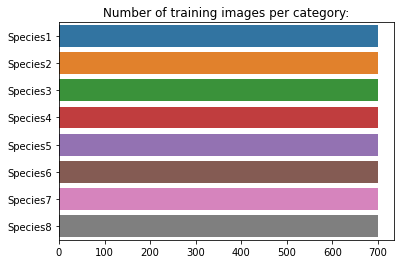

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
category_names = sorted(os.listdir(training_dir))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = training_dir + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=180,
                                        height_shift_range=5,
                                        width_shift_range=5,
                                        #zoom_range=0.5,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        #fill_mode='nearest',
                                        preprocessing_function = preprocess_input,
                                        # rescale=1/255. not on vgg16
                                        ) 
valid_data_gen = ImageDataGenerator(#rescale=1/255.,
                                    preprocessing_function = preprocess_input)
test_data_gen = ImageDataGenerator(#rescale=1/255.,
                                   preprocessing_function = preprocess_input)

In [9]:
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=32,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(96,96),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=False,
                                             seed=seed)

Found 5600 images belonging to 8 classes.
Found 527 images belonging to 8 classes.
Found 361 images belonging to 8 classes.


In [10]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

(Input) image shape: (32, 96, 96, 3)
Target shape: (32, 8)

Categorical label: [0. 0. 0. 0. 0. 0. 1. 0.]
Label: 6
Class name: Species7


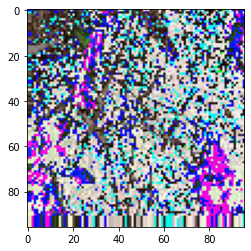

In [11]:
# Get a sample from dataset and show info
_ = get_next_batch(aug_train_gen)

In [12]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                              

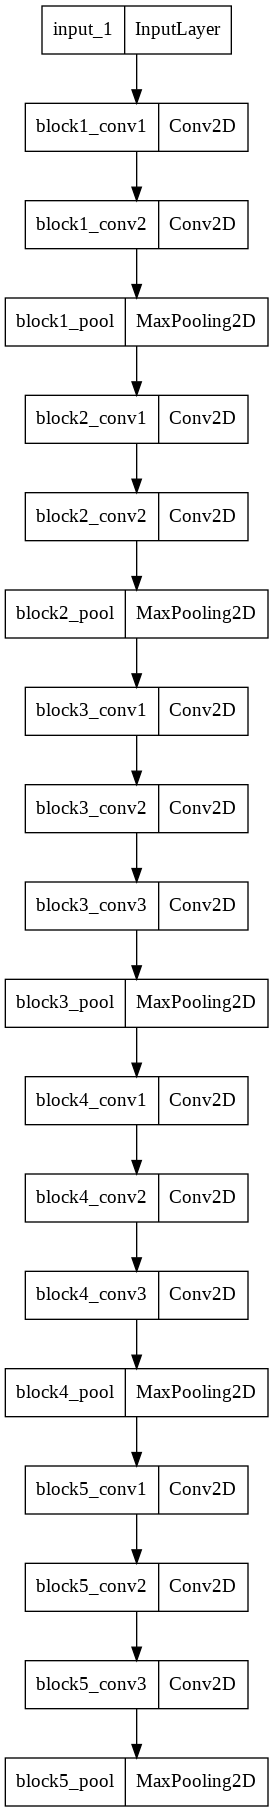

In [13]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [14]:
input_shape = (96, 96, 3)
epochs = 200

In [15]:
import tensorflow.keras.layers as tfkl

# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(96,96,3))
# No resize
#x = tfkl.Resizing(64, 64, interpolation="bicubic")(inputs)
x = supernet(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)



# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')

# Compile the model
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [16]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   layer.trainable = False

for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [17]:
# Train the model
tl_callbacks = create_folders_and_callbacks(model_name = 'transfer_learning')

# Train the model
tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = tl_callbacks,
    #class_weight=class_weight
).history

Epoch 1/200
175/175 [==============================] - ETA: 0s - loss: 4.1111 - accuracy: 0.3434 - precision: 0.4034 - recall: 0.2314

175/175 [==============================] - 855s 5s/step - loss: 4.1111 - accuracy: 0.3434 - precision: 0.4034 - recall: 0.2314 - val_loss: 1.4828 - val_accuracy: 0.4175 - val_precision: 0.6214 - val_recall: 0.2429
Epoch 2/200
175/175 [==============================] - ETA: 0s - loss: 1.5930 - accuracy: 0.4271 - precision: 0.5922 - recall: 0.2570

175/175 [==============================] - 29s 164ms/step - loss: 1.5930 - accuracy: 0.4271 - precision: 0.5922 - recall: 0.2570 - val_loss: 1.4471 - val_accuracy: 0.4554 - val_precision: 0.6375 - val_recall: 0.3036
Epoch 3/200
175/175 [==============================] - ETA: 0s - loss: 1.4706 - accuracy: 0.4570 - precision: 0.6184 - recall: 0.2789

175/175 [==============================] - 30s 169ms/step - loss: 1.4706 - accuracy: 0.4570 - precision: 0.6184 - recall: 0.2789 - val_loss: 1.2814 - val_accuracy: 0.5199 - val_precision: 0.6877 - val_recall: 0.3510
Epoch 4/200
175/175 [==============================] - ETA: 0s - loss: 1.3517 - accuracy: 0.4954 - precision: 0.6454 - recall: 0.3221

175/175 [==============================] - 29s 165ms/step - loss: 1.3517 - accuracy: 0.4954 - precision: 0.6454 - recall: 0.3221 - val_loss: 1.2402 - val_accuracy: 0.5218 - val_precision: 0.6752 - val_recall: 0.3510
Epoch 5/200
175/175 [==============================] - ETA: 0s - loss: 1.2943 - accuracy: 0.5071 - precision: 0.6666 - recall: 0.3405

175/175 [==============================] - 29s 168ms/step - loss: 1.2943 - accuracy: 0.5071 - precision: 0.6666 - recall: 0.3405 - val_loss: 1.3687 - val_accuracy: 0.4706 - val_precision: 0.6466 - val_recall: 0.3055
Epoch 6/200
175/175 [==============================] - ETA: 0s - loss: 1.2760 - accuracy: 0.5161 - precision: 0.6734 - recall: 0.3550

175/175 [==============================] - 29s 165ms/step - loss: 1.2760 - accuracy: 0.5161 - precision: 0.6734 - recall: 0.3550 - val_loss: 1.2576 - val_accuracy: 0.5370 - val_precision: 0.6601 - val_recall: 0.3833
Epoch 7/200
175/175 [==============================] - ETA: 0s - loss: 1.2222 - accuracy: 0.5470 - precision: 0.6930 - recall: 0.3821

175/175 [==============================] - 30s 169ms/step - loss: 1.2222 - accuracy: 0.5470 - precision: 0.6930 - recall: 0.3821 - val_loss: 1.3372 - val_accuracy: 0.5294 - val_precision: 0.6834 - val_recall: 0.4137
Epoch 8/200
175/175 [==============================] - ETA: 0s - loss: 1.1828 - accuracy: 0.5571 - precision: 0.6900 - recall: 0.3930

175/175 [==============================] - 29s 165ms/step - loss: 1.1828 - accuracy: 0.5571 - precision: 0.6900 - recall: 0.3930 - val_loss: 1.2416 - val_accuracy: 0.5294 - val_precision: 0.6783 - val_recall: 0.4042
Epoch 9/200
175/175 [==============================] - ETA: 0s - loss: 1.1626 - accuracy: 0.5604 - precision: 0.7032 - recall: 0.4109

175/175 [==============================] - 30s 171ms/step - loss: 1.1626 - accuracy: 0.5604 - precision: 0.7032 - recall: 0.4109 - val_loss: 1.2156 - val_accuracy: 0.5332 - val_precision: 0.6821 - val_recall: 0.3909
Epoch 10/200
175/175 [==============================] - ETA: 0s - loss: 1.1494 - accuracy: 0.5652 - precision: 0.7027 - recall: 0.4175

175/175 [==============================] - 29s 167ms/step - loss: 1.1494 - accuracy: 0.5652 - precision: 0.7027 - recall: 0.4175 - val_loss: 1.1652 - val_accuracy: 0.5636 - val_precision: 0.7081 - val_recall: 0.4326
Epoch 11/200
175/175 [==============================] - ETA: 0s - loss: 1.1187 - accuracy: 0.5841 - precision: 0.7221 - recall: 0.4477

175/175 [==============================] - 30s 172ms/step - loss: 1.1187 - accuracy: 0.5841 - precision: 0.7221 - recall: 0.4477 - val_loss: 1.1263 - val_accuracy: 0.5863 - val_precision: 0.7194 - val_recall: 0.4231
Epoch 12/200
175/175 [==============================] - ETA: 0s - loss: 1.1192 - accuracy: 0.5879 - precision: 0.7223 - recall: 0.4395

175/175 [==============================] - 29s 166ms/step - loss: 1.1192 - accuracy: 0.5879 - precision: 0.7223 - recall: 0.4395 - val_loss: 1.1073 - val_accuracy: 0.5579 - val_precision: 0.6945 - val_recall: 0.4099
Epoch 13/200
175/175 [==============================] - ETA: 0s - loss: 1.0975 - accuracy: 0.5886 - precision: 0.7131 - recall: 0.4371

175/175 [==============================] - 30s 171ms/step - loss: 1.0975 - accuracy: 0.5886 - precision: 0.7131 - recall: 0.4371 - val_loss: 1.1440 - val_accuracy: 0.5731 - val_precision: 0.7121 - val_recall: 0.4364
Epoch 14/200
175/175 [==============================] - ETA: 0s - loss: 1.0805 - accuracy: 0.5987 - precision: 0.7315 - recall: 0.4684

175/175 [==============================] - 29s 163ms/step - loss: 1.0805 - accuracy: 0.5987 - precision: 0.7315 - recall: 0.4684 - val_loss: 1.1840 - val_accuracy: 0.5484 - val_precision: 0.6815 - val_recall: 0.4345
Epoch 15/200
175/175 [==============================] - ETA: 0s - loss: 1.0924 - accuracy: 0.5914 - precision: 0.7268 - recall: 0.4555

175/175 [==============================] - 29s 165ms/step - loss: 1.0924 - accuracy: 0.5914 - precision: 0.7268 - recall: 0.4555 - val_loss: 1.1927 - val_accuracy: 0.5465 - val_precision: 0.6774 - val_recall: 0.4383
Epoch 16/200
175/175 [==============================] - ETA: 0s - loss: 1.0653 - accuracy: 0.5846 - precision: 0.7218 - recall: 0.4480

175/175 [==============================] - 29s 167ms/step - loss: 1.0653 - accuracy: 0.5846 - precision: 0.7218 - recall: 0.4480 - val_loss: 1.1534 - val_accuracy: 0.5503 - val_precision: 0.6557 - val_recall: 0.4554
Epoch 17/200
175/175 [==============================] - ETA: 0s - loss: 1.0629 - accuracy: 0.6086 - precision: 0.7431 - recall: 0.4732

175/175 [==============================] - 29s 164ms/step - loss: 1.0629 - accuracy: 0.6086 - precision: 0.7431 - recall: 0.4732 - val_loss: 1.1140 - val_accuracy: 0.5427 - val_precision: 0.6887 - val_recall: 0.3947
Epoch 18/200
175/175 [==============================] - ETA: 0s - loss: 1.0335 - accuracy: 0.6086 - precision: 0.7402 - recall: 0.4768

175/175 [==============================] - 29s 168ms/step - loss: 1.0335 - accuracy: 0.6086 - precision: 0.7402 - recall: 0.4768 - val_loss: 1.1128 - val_accuracy: 0.5655 - val_precision: 0.7033 - val_recall: 0.4497
Epoch 19/200
175/175 [==============================] - ETA: 0s - loss: 1.0642 - accuracy: 0.6037 - precision: 0.7356 - recall: 0.4795

175/175 [==============================] - 29s 163ms/step - loss: 1.0642 - accuracy: 0.6037 - precision: 0.7356 - recall: 0.4795 - val_loss: 1.0873 - val_accuracy: 0.5731 - val_precision: 0.7087 - val_recall: 0.4801
Epoch 20/200
175/175 [==============================] - ETA: 0s - loss: 1.0472 - accuracy: 0.6107 - precision: 0.7429 - recall: 0.4795

175/175 [==============================] - 29s 167ms/step - loss: 1.0472 - accuracy: 0.6107 - precision: 0.7429 - recall: 0.4795 - val_loss: 1.1793 - val_accuracy: 0.5104 - val_precision: 0.6540 - val_recall: 0.4231
Epoch 21/200
175/175 [==============================] - ETA: 0s - loss: 1.0561 - accuracy: 0.6162 - precision: 0.7425 - recall: 0.4732

175/175 [==============================] - 29s 164ms/step - loss: 1.0561 - accuracy: 0.6162 - precision: 0.7425 - recall: 0.4732 - val_loss: 1.0879 - val_accuracy: 0.5901 - val_precision: 0.6976 - val_recall: 0.4421
Epoch 22/200
175/175 [==============================] - ETA: 0s - loss: 1.0348 - accuracy: 0.6177 - precision: 0.7475 - recall: 0.4921

175/175 [==============================] - 29s 167ms/step - loss: 1.0348 - accuracy: 0.6177 - precision: 0.7475 - recall: 0.4921 - val_loss: 1.0718 - val_accuracy: 0.5806 - val_precision: 0.6965 - val_recall: 0.4877
Epoch 23/200
175/175 [==============================] - ETA: 0s - loss: 1.0175 - accuracy: 0.6184 - precision: 0.7411 - recall: 0.4918

175/175 [==============================] - 29s 163ms/step - loss: 1.0175 - accuracy: 0.6184 - precision: 0.7411 - recall: 0.4918 - val_loss: 1.1300 - val_accuracy: 0.5787 - val_precision: 0.7130 - val_recall: 0.4668
Epoch 24/200
175/175 [==============================] - ETA: 0s - loss: 1.0320 - accuracy: 0.6209 - precision: 0.7464 - recall: 0.4920

175/175 [==============================] - 29s 166ms/step - loss: 1.0320 - accuracy: 0.6209 - precision: 0.7464 - recall: 0.4920 - val_loss: 1.0845 - val_accuracy: 0.5882 - val_precision: 0.7373 - val_recall: 0.4687
Epoch 25/200
175/175 [==============================] - ETA: 0s - loss: 1.0346 - accuracy: 0.6164 - precision: 0.7445 - recall: 0.4880

175/175 [==============================] - 29s 164ms/step - loss: 1.0346 - accuracy: 0.6164 - precision: 0.7445 - recall: 0.4880 - val_loss: 1.1164 - val_accuracy: 0.5731 - val_precision: 0.7053 - val_recall: 0.4269
Epoch 26/200
175/175 [==============================] - ETA: 0s - loss: 1.0106 - accuracy: 0.6263 - precision: 0.7497 - recall: 0.5066

175/175 [==============================] - 28s 162ms/step - loss: 1.0106 - accuracy: 0.6263 - precision: 0.7497 - recall: 0.5066 - val_loss: 1.0862 - val_accuracy: 0.5617 - val_precision: 0.6859 - val_recall: 0.4516
Epoch 27/200
175/175 [==============================] - ETA: 0s - loss: 1.0032 - accuracy: 0.6268 - precision: 0.7614 - recall: 0.4986

175/175 [==============================] - 29s 168ms/step - loss: 1.0032 - accuracy: 0.6268 - precision: 0.7614 - recall: 0.4986 - val_loss: 1.0694 - val_accuracy: 0.5693 - val_precision: 0.6885 - val_recall: 0.4782
Epoch 28/200
175/175 [==============================] - ETA: 0s - loss: 1.0201 - accuracy: 0.6145 - precision: 0.7410 - recall: 0.4971

175/175 [==============================] - 29s 164ms/step - loss: 1.0201 - accuracy: 0.6145 - precision: 0.7410 - recall: 0.4971 - val_loss: 1.2031 - val_accuracy: 0.5332 - val_precision: 0.6288 - val_recall: 0.4307
Epoch 29/200
175/175 [==============================] - ETA: 0s - loss: 0.9911 - accuracy: 0.6305 - precision: 0.7614 - recall: 0.5116

175/175 [==============================] - 30s 169ms/step - loss: 0.9911 - accuracy: 0.6305 - precision: 0.7614 - recall: 0.5116 - val_loss: 1.1649 - val_accuracy: 0.5560 - val_precision: 0.6629 - val_recall: 0.4440
Epoch 30/200
175/175 [==============================] - ETA: 0s - loss: 1.0022 - accuracy: 0.6239 - precision: 0.7493 - recall: 0.5002

175/175 [==============================] - 28s 160ms/step - loss: 1.0022 - accuracy: 0.6239 - precision: 0.7493 - recall: 0.5002 - val_loss: 1.0740 - val_accuracy: 0.5579 - val_precision: 0.6835 - val_recall: 0.4630
Epoch 31/200
175/175 [==============================] - ETA: 0s - loss: 1.0100 - accuracy: 0.6364 - precision: 0.7561 - recall: 0.5021

175/175 [==============================] - 30s 169ms/step - loss: 1.0100 - accuracy: 0.6364 - precision: 0.7561 - recall: 0.5021 - val_loss: 1.0735 - val_accuracy: 0.5731 - val_precision: 0.7139 - val_recall: 0.4687


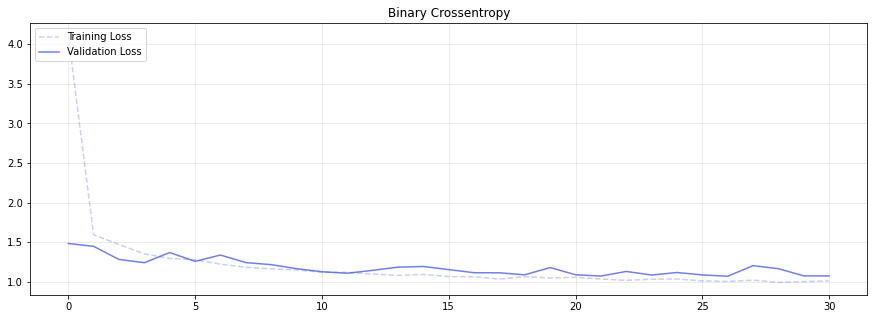

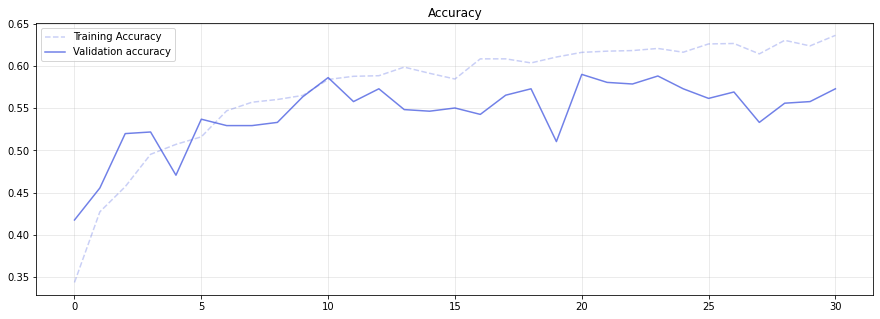

In [18]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [19]:
tl_model.save('Vgg16/FineFineTuning_v1')

In [20]:
tl_model = tfk.models.load_model('Vgg16/FineFineTuning_v1')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [21]:
tl_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [22]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers[:15]):
  layer.trainable=False
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0       

In [23]:
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [24]:
# Fine-tune the model
tl_history = tl_model.fit(
    x = aug_train_gen ,
    batch_size = 32,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=2 , restore_best_weights=True)],
    #class_weight = class_weight
).history

Epoch 1/200
175/175 [==============================] - 27s 138ms/step - loss: 1.2051 - accuracy: 0.5673 - precision_1: 0.7012 - recall_1: 0.4148 - val_loss: 1.1587 - val_accuracy: 0.6053 - val_precision_1: 0.6946 - val_recall_1: 0.5351
Epoch 2/200
175/175 [==============================] - 24s 137ms/step - loss: 1.0157 - accuracy: 0.6352 - precision_1: 0.7579 - recall_1: 0.5059 - val_loss: 0.9182 - val_accuracy: 0.6452 - val_precision_1: 0.7474 - val_recall_1: 0.5503
Epoch 3/200
175/175 [==============================] - 24s 135ms/step - loss: 0.8790 - accuracy: 0.6834 - precision_1: 0.7861 - recall_1: 0.5598 - val_loss: 1.0519 - val_accuracy: 0.6262 - val_precision_1: 0.7313 - val_recall_1: 0.5579
Epoch 4/200
175/175 [==============================] - 23s 134ms/step - loss: 0.8350 - accuracy: 0.6927 - precision_1: 0.7927 - recall_1: 0.5968 - val_loss: 1.0140 - val_accuracy: 0.6831 - val_precision_1: 0.7617 - val_recall_1: 0.6186
Epoch 5/200
175/175 [==============================] - 2

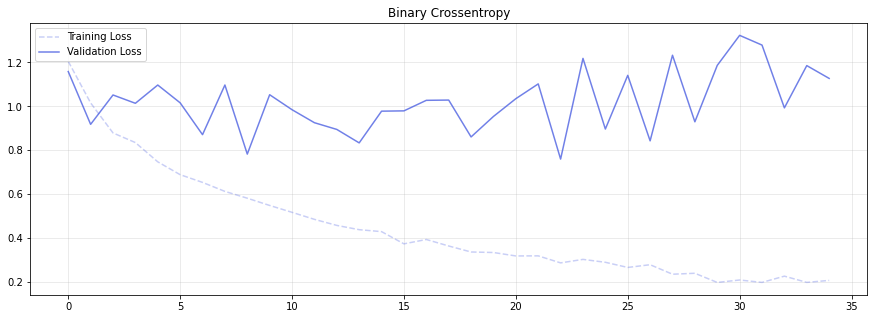

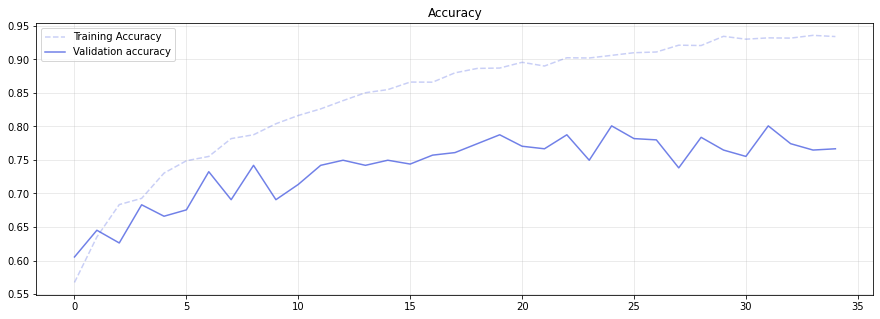

In [25]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [26]:
%cd /gdrive/My Drive/ANDL/Homework_1

/gdrive/My Drive/ANDL/Homework_1


In [27]:
tl_model.save('Vgg16/Tuned_v1_1')

In [28]:
# Test the model
tl_model = tfk.models.load_model("Vgg16/Tuned_v1_1")
model_test_metrics = tl_model.evaluate(test_gen, return_dict=True)

print()
print("Test metrics")
print(model_test_metrics)

12/12 [==============================] - 52s 5s/step - loss: 0.8395 - accuracy: 0.8116 - precision_1: 0.8244 - recall_1: 0.8061

Test metrics
{'loss': 0.8394734859466553, 'accuracy': 0.811634361743927, 'precision_1': 0.8243626356124878, 'recall_1': 0.8060941696166992}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


Accuracy: 0.8116
Precision: 0.8097
Recall: 0.7697
F1: 0.779


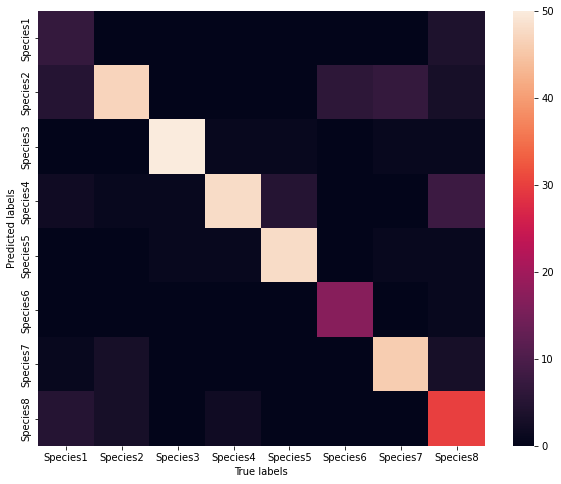

In [29]:
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = tl_model.predict_generator(test_gen, steps=224)
predicted_classes = np.argmax(predictions, axis=-1)

# Compute the confusion matrix
cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()